In [12]:
%matplotlib inline
import keras 
from keras.applications import xception
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from utils import breed_overview, store_data_hdf5, hdf5_image_generator, get_steps, get_labels, plot_image_overview, get_images
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

%pylab inline
pylab.rcParams['figure.figsize'] = (16,16)

1.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16613749714244533456
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 51511296
locality {
  bus_id: 1
}
incarnation: 4308191012523693506
physical_device_desc: "device: 0, name: Quadro M1000M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [2]:
root_dir = "/home/anne/src/dog_identification/"  
train_zip = root_dir + "data/train.zip"
valid_zip = root_dir + "data/valid.zip"
training_filename = root_dir + "data/train.p"
validation_filename = root_dir + "data/valid.p"
labels_filename = root_dir + "data/labels.csv.zip"
hdf5_filename = root_dir + "data/images.hdf5"

train_val = 0.8 # trian/val
batch_size = 15 # Amount of images to load into each batch

n_breeds = 40 # total number of breeds

img_size = 299

### Load datasets

In [3]:
# Load the whole dataset into memory
store_data_hdf5(train_zip, labels_filename, hdf5_filename,store_size=img_size, train_val=0.8)

HDF5 file already exists, continueing


In [4]:
def preprocessing_function(img):
    return xception.preprocess_input(np.expand_dims(img.astype(float).copy(), axis=0))

# Create the generators, that provide the images

x_train_generator = hdf5_image_generator(hdf5_filename, batch_size=batch_size, n_breeds=n_breeds, image_preprocessor=preprocessing_function)
x_val_generator = hdf5_image_generator(hdf5_filename, batch_size=batch_size, n_breeds=n_breeds, image_preprocessor=preprocessing_function, training=False)

train_steps, val_steps = get_steps(hdf5_filename, batch_size=batch_size, n_breeds=n_breeds)

### Create model

In [5]:
xception_bottleneck = xception.Xception(weights = "imagenet", include_top=False, pooling='avg')


train_x_bf = xception_bottleneck.predict_generator(x_train_generator, steps=train_steps, verbose=1)
valid_x_bf = xception_bottleneck.predict_generator(x_val_generator, steps=val_steps, verbose=1)

print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

52/52 [==============================] - 80s 2s/step
Xception train bottleneck features shape: (3252, 2048) size: 6,660,096
Xception valid bottleneck features shape: (777, 2048) size: 1,591,296


### Train new model

In [6]:
y_train, y_val, breed_dict = get_labels(hdf5_filename, n_breeds)

y_val_hot = keras.utils.to_categorical(y_val)
y_train_hot = keras.utils.to_categorical(y_train)

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=6)
logreg.fit(train_x_bf, (y_train_hot * range(n_breeds)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(y_val_hot, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((y_val_hot * range(n_breeds)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.154196653902
Validation Xception Accuracy 0.945945945946


### Evaluate

(12, 299, 299, 3)


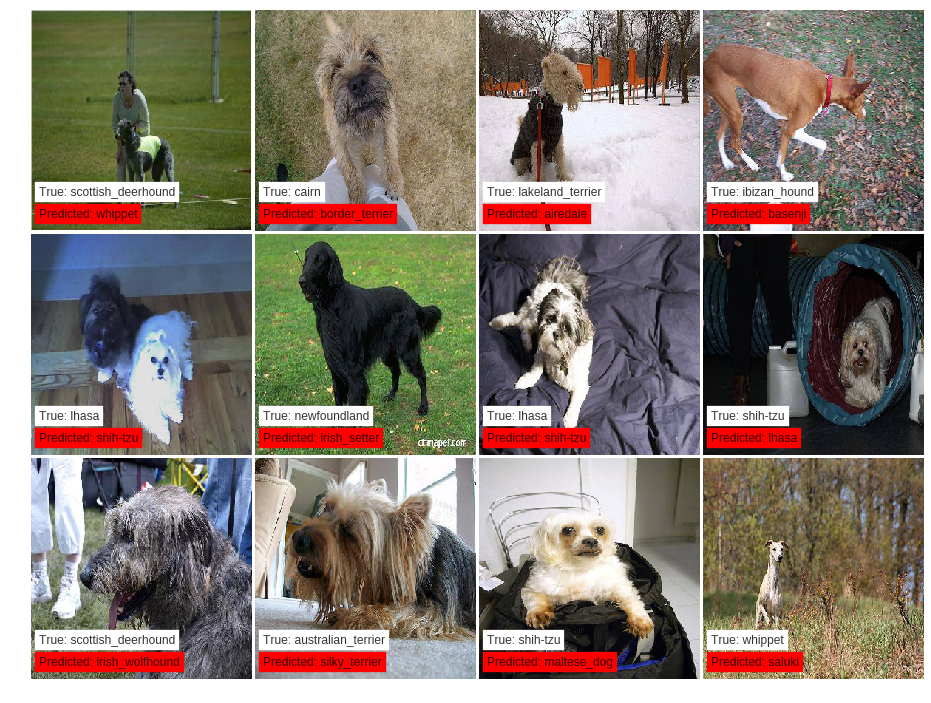

In [11]:
# print valid_preds.shape
false_indexes = ~np.equal(y_val, valid_preds)
# Set first 8 arguments as True for displaying purposes
# false_indexes[0:8] = True
false_indexes = np.flatnonzero(false_indexes)[0:12]
true_labels = breed_dict[y_val[false_indexes]]
pred_labels = breed_dict[valid_preds[false_indexes].astype(int)]
images_val = get_images(hdf5_filename, false_indexes, n_breeds=n_breeds, train=False)
print images_val.shape
# print false_indexes.sum()
plot_image_overview(images_val, true_labels, pred_labels)

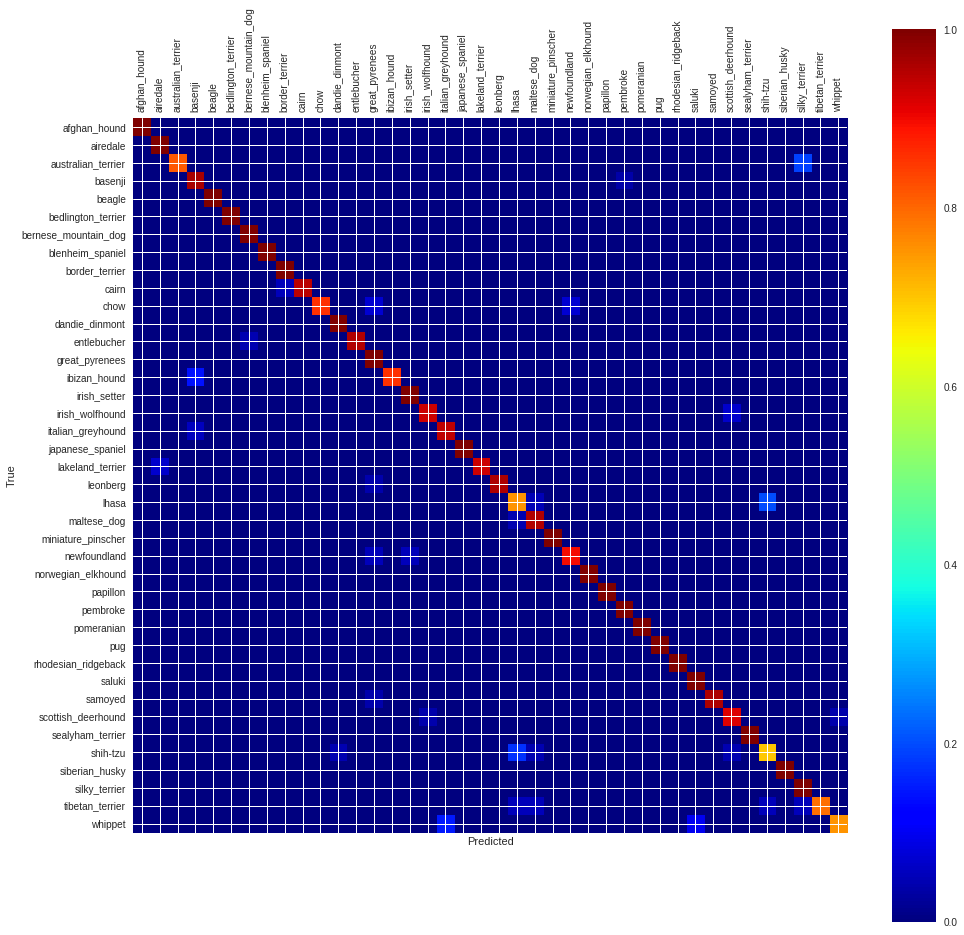

In [53]:
def plot_confusion_matrix(data_true_cls,data_pred_cls, breed_dict, n_breeds):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
  
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=data_true_cls,
                          y_pred=data_pred_cls)
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Print the confusion matrix as text.
#     print(cm)
    plt.matshow(cm_norm, cmap='jet')

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(n_breeds)
    plt.xticks(tick_marks, breed_dict[range(n_breeds)], rotation='vertical')
    plt.yticks(tick_marks, breed_dict[range(n_breeds)])
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()
    return cm

cm = plot_confusion_matrix(y_val, valid_preds.astype(int), breed_dict, n_breeds)

In [74]:
cm_eq_ind = cm.nonzero()
# Remove matching breeds (only errors)
cm_err_mask = ~np.equal(cm_eq_ind[0], cm_eq_ind[1])
cm_eq_ind = (cm_eq_ind[0][cm_err_mask], cm_eq_ind[1][cm_err_mask])

print cm[cm_eq_ind]

# Create horizontal bar chart of breed errors
def conf_overview(cm):
    pass
    

[3 1 1 1 1 1 3 1 1 1 1 1 4 1 1 1 1 1 1 1 4 1 1 1 1 1 1 3 2]


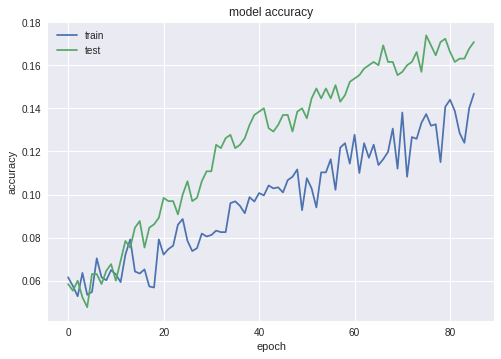

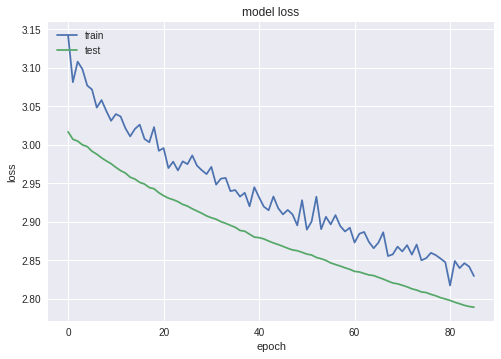